In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("Downloads/Google stock price HistoricalData_1761518911391.csv")

In [3]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/24/2025,$260.51,18405970,$257.30,$262.51,$256.10
1,10/23/2025,$253.73,13241320,$253.70,$255.86,$252.7683
2,10/22/2025,$252.53,19650240,$255.01,$257.18,$250.451
3,10/21/2025,$251.34,27836430,$255.25,$255.38,$244.67
4,10/20/2025,$257.02,13726830,$255.23,$257.88,$254.60


In [4]:
# To remove dollor symbol and make DateTime Object-
data = data.replace({'$': ''}, regex=True)
data["Date"]=pd.to_datetime(data["Date"])
data

,Date,Close/Last,Volume,Open,High,Low
0,2025-10-24,$260.51,18405970,$257.30,$262.51,$256.10
1,2025-10-23,$253.73,13241320,$253.70,$255.86,$252.7683
2,2025-10-22,$252.53,19650240,$255.01,$257.18,$250.451
3,2025-10-21,$251.34,27836430,$255.25,$255.38,$244.67
4,2025-10-20,$257.02,13726830,$255.23,$257.88,$254.60
...,...,...,...,...,...,...
1250,2020-11-02,$81.3015,50708920,$81.408,$83.0385,$80.8015
1251,2020-10-30,$81.0505,86617240,$83.6055,$84.35,$80.223
1252,2020-10-29,$78.362,40061280,$76.118,$79.6855,$76.112
1253,2020-10-28,$75.831,36679180,$77.987,$78.0675,$75.731


In [5]:
data["Open"] = data["Open"].str.replace('$', '', regex=False).astype(float)
data["Open"].head()
# # Here we Remove the dollar sign from the 'Open' column and convert it to numeric (float) format.


0    257.30
1    253.70
2    255.01
3    255.25
4    255.23
Name: Open, dtype: float64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1255 non-null   datetime64[ns]
 1   Close/Last  1255 non-null   object        
 2   Volume      1255 non-null   int64         
 3   Open        1255 non-null   float64       
 4   High        1255 non-null   object        
 5   Low         1255 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 59.0+ KB


# Spliting Data as Train and Validation.


# Why date is included in train_data?
The Date column in train_data is not used as an input feature but is kept to preserve the time order, support plotting, and enable future feature engineering.

In [9]:
length_data=len(data)
split_ratio=0.7 # (70% for train , 30% test(validation))
length_train_data=round(length_data*split_ratio)
length_validation_data=length_data-length_train_data
print("Data Length:-",length_data)
print("Train data length:-",length_train_data)
print("Test(Validation) data length:-",length_validation_data)

Data Length:- 1255
Train data length:- 878
Test(Validation) data length:- 377


In [10]:
train_data = data[["Date","Open"]] 
train_data=train_data[:length_train_data]
train_data

,Date,Open
0,2025-10-24,257.3000
1,2025-10-23,253.7000
2,2025-10-22,255.0100
3,2025-10-21,255.2500
4,2025-10-20,255.2300
...,...,...
873,2022-05-03,116.7650
874,2022-05-02,113.9065
875,2022-04-29,117.5780
876,2022-04-28,117.1150


In [11]:
validation_data = data[["Date","Open"]] 
validation_data=validation_data[:length_validation_data]
validation_data

,Date,Open
0,2025-10-24,257.30
1,2025-10-23,253.70
2,2025-10-22,255.01
3,2025-10-21,255.25
4,2025-10-20,255.23
...,...,...
372,2024-05-01,166.18
373,2024-04-30,167.38
374,2024-04-29,170.77
375,2024-04-26,175.99


# Preparing the Open Price Data for RNN Input by Convert ‘Open’ Column to 2D NumPy Array.
why needed?? - Reshaping to (n,1) is necessary and useful before normalization and RNN training. 
#It standardizes your data shape so that further steps (like scaling and sequence building) work smoothly.
#Most ML models (including scalers like MinMaxScaler and RNN/LSTM) expect 2D input arrays, not 1D.

The general input shape convention is:
(number of samples, number of features)
     Here:
    samples = 1184 (days)

    features = 1 (Open price only)

So (1184, 1) tells the model:
→ “We have 1184 observations, each with one feature value.”


Now we will extrat Stock's "Open" Price from train_data as 1D-Numpy array

In [14]:
open_price_1D=train_data.Open.values
open_price_1D.shape

(878,)

Now change this 1D array to 2D array from shape (878,) to (878,1)

In [16]:
open_price_1D_clean=data["Open"]
open_price_2D= np.array(open_price_1D_clean,dtype=float).reshape (-1,1)
open_price_2D.shape

(1255, 1)

What np.reshape(dataset_train, (-1, 1)) does

np.reshape changes the shape of the array without changing its data.

The argument (-1, 1) means:

-1 → “figure out automatically how many rows I need”

1 → “make 1 column”

So it converts your data from shape
(1184,) → (1184, 1)

RNNs (and LSTMs) ultimately expect 3D input of shape:
(samples, timesteps, features)

# 4.Normalization / Feature Scaling

Dataset values will be in between 0 and 1 after scaling

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
open_price_2D_Scaled = scaler.fit_transform(open_price_2D)

open_price_2D_Scaled.shape


(1255, 1)

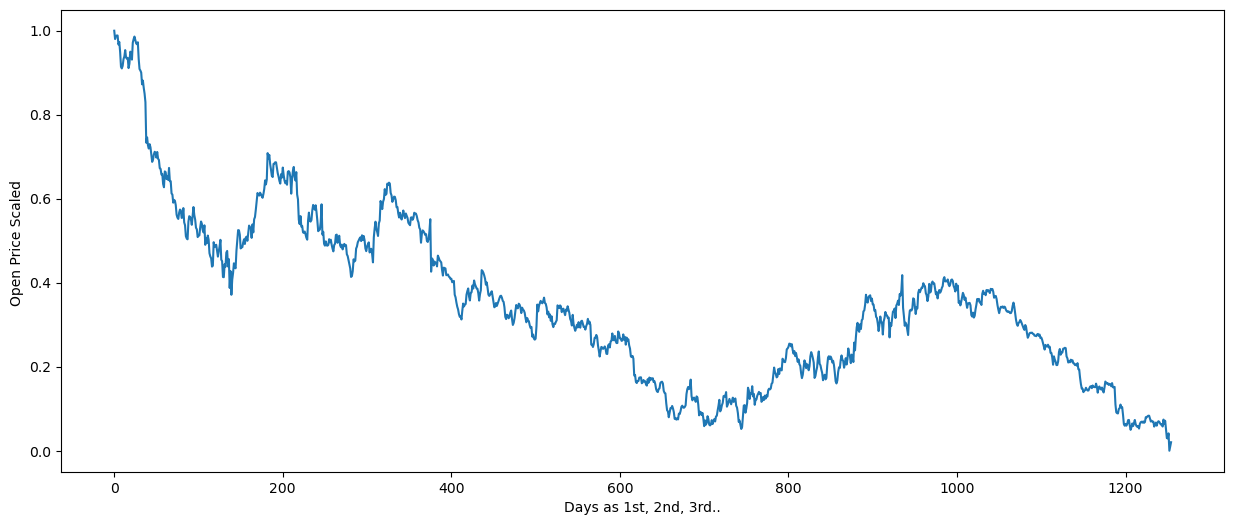

In [21]:
plt.subplots(figsize = (15,6))
plt.plot(open_price_2D_Scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price Scaled ")
plt.show()


# Creating X_train and y_train from Train data for RNN for Prediction 



<!-- -We have train data composed of stock open prices over days.
-So, it has 1184 prices corresponding 1184 days.
-My aim is to predict the open price of the next day.
-I can use a time step of 50 days.
-I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data.
-Then predict the price of 51th day; and 51th price will be in y_train data.
-Again, i will pick prices from 1 to 51, those will be in X_train data.
-Then predict the next days price, 52nd price will be in y_train data. -->

In [24]:
# We have train data composed of stock open prices over days
# So, it has 1184 prices corresponding 1184 days
# My aim is to predict the open price of the next day.
# I can use a time step of 50 days.
# I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
# Then predict the price of 51th day; and 51th price will be in y_train data
# Again, i will pick prices from 1 to 51, those will be in X_train data
# Then predict the next days price, 52nd price will be in y_train data

In [25]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step,length_train_data):
    X_train.append(open_price_2D_Scaled[i-time_step:i,0])
    y_train.append(open_price_2D_Scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)


In [26]:
# ✅ NOTE-- Python indexing starts from 0.

# So the first day → index 0, second day → index 1, and so on.

# In our loop:

# Input window → i-time_step : i (e.g., 0:50 → days 1–50)

# Target → index i (e.g., 50 → day 51).

# Hence, index 50 corresponds to the 51st day’s price. 🔁


# Inside loop for i in range(50,878) so loop runs for i=50,51,..,877, so loop runs for "The number of iterations = last index − first index "
# Now shape wil be 878-50=828 these 828 are training samples 
# step 1- range(time_step, length_train_data) means:

# start at i = time_step, end at i = length_train_data - 1.

# Example:
# If time_step = 50 and length_train_data = 1184,
# then i takes values 50, 51, 52, …, 1183 → total of 1134 iterations.

# Each iteration produces one training sample (one X and one y).

# ** step 2- The input sequence (X) **
# X_train.append(open_price_2D_Scaled[i - time_step : i, 0])
# What happens here:

# i - time_step : i → slices 50 rows before index i (so row 0 to 49)
# → these are the previous 50 days.

# , 0 → selects the first (and only) column (since array is 2D).

# 👉 Each X_train[i] = the last 50 prices before day i. {for i =50 we have last previous 50 days price from 0 day to 49th day.}

# **Step 3: The target value (y)**
# y_train.append(open_price_2D_Scaled[i, 0])
# This picks the price at index i (the day right after your 50-day window).

# So:

# For i = 50, y_train gets price of day 51. {that's 50th day price }

# For i = 51, y_train gets price of day 52. { that's 51th day price }

# …

# 👉 Each y_train[i] = the next day’s open price. 

In [27]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (828, 50)
Shape of y_train before reshape : (828,)


In [28]:
# Now Reshape this.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (828, 50, 1)
Shape of y_train after reshape : (828, 1)


In [29]:
#-Shape of X_train : 828 x 50 x 1
#-That means we have 828 rows, each row has 50 rows and 1 column
#-Lets check the first row: it has 50 rows (open prices of 1st 50 days i.e, index i=0 to i=49) 
# similarly X_train[j] = the j-th input sample (window), X_train[j]=[pj​,pj+1​,…,pj+time_step−1​],
# Example (if time_step = 50):

# X_train[0] → prices of days 1–50

# X_train[1] → prices of days 2–51

# X_train[2] → prices of days 3–52


X_train[0]   # Days 1–50 (input window)
X_train[0].shape

(50, 1)

In [30]:
#Check the first item in y_train,
#It is the price of 51st day,
y_train[0]

array([0.69787286])

# Creating RNN model

In [32]:
# ✅ 1. Importing Libraries

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

# Sequential → lets you build a neural network layer-by-layer.

# SimpleRNN → vanilla recurrent neural network layer.

# Dense → fully connected (output) layer.

# Dropout → regularization to prevent overfitting.

In [33]:
# ✅ 2. Initializing the RNN

regressor = Sequential()

# Creates an empty model where layers will be added one after another.

In [34]:
# ✅ 3. First RNN Layer + Dropout

regressor.add(
    SimpleRNN(units=50, activation="tanh",
              return_sequences=True,
              input_shape=(X_train.shape[1], 1))
)

regressor.add(Dropout(0.2))

# Explanation:

# units = 50 → 50 memory cells / neurons in this RNN layer.

# activation = "tanh" → standard activation for RNNs, keeps values between −1 and 1.

# return_sequences = True → outputs the full sequence for the next RNN layer (needed when stacking RNN layers).

# input_shape = (timesteps, features)
# X_train.shape[1] = number of timesteps.
# 1 = one feature (open price).

# Dropout(0.2) → randomly drops 20% of neurons during training to reduce overfitting.

C:\Users\harry\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
# ✅ 4. Second RNN Layer + Dropout

regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))

# Same as first layer, but you don’t specify input shape.

# return_sequences=True → because you will add another RNN layer after this.

In [36]:
# ✅ 5. Third RNN Layer + Dropout

regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))

# Still returning sequences because there is another RNN layer coming.

In [37]:
# ✅ 6. Fourth (final) RNN Layer + Dropout

regressor.add(SimpleRNN(units=50))
regressor.add(Dropout(0.2))

# return_sequences=False (default)
# because after this there is no more RNN layer, so we don’t need to return the full sequence—just the final hidden state.

In [38]:
# ✅ 7. Output Layer

regressor.add(Dense(units=1))

# Fully connected layer

# units=1 → predicting one value (tomorrow's scaled open price)

In [39]:
# ✅ 8. Compile the RNN

regressor.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mae"]
)

# Explanation:

# optimizer = “adam”
# Adaptive learning rate gradient descent.

# loss = MSE
# Standard loss for regression problems.

# metrics = ["accuracy"]

In [40]:
# ✅ 9. Train the Model

history = regressor.fit(X_train, y_train, epochs=50, batch_size=32)

# Explanation:

# X_train: input sequences

# y_train: corresponding next-day price

# epochs = 50: model sees the full dataset 50 times

# batch_size = 32: gradient update every 32 samples

# history: stores loss curves


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.4153 - mae: 0.5072
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2883 - mae: 0.4262
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2241 - mae: 0.3740
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1808 - mae: 0.3349
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1539 - mae: 0.3116
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1200 - mae: 0.2762
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1010 - mae: 0.2520
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0830 - mae: 0.2272
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0656 - mae: 0.2031
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0608 - mae: 0.1955
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0573 - mae: 0.1902
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0517 - mae: 0.1794
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━

In [41]:
# 🔥 Final Summary-

# we built a 4-layer deep RNN:

# Each layer has 50 units.

# tanh activation.

# Dropout after every layer.

# Final Dense(1) for regression output.

# Optimized with Adam + MSE loss.

# Trained for 50 epochs.

# This model predicts the next day’s open price based on previous timesteps.

# Evaluating Model



In [43]:
# Losses
history.history["loss"]

# It tells how much error our model had at each epoch and whether it learned properly.

[0.4153232276439667,
 0.2883063852787018,
 0.2241133600473404,
 0.1807500272989273,
 0.15393932163715363,
 0.1199687272310257,
 0.10098721086978912,
 0.083038330078125,
 0.06558306515216827,
 0.06079995632171631,
 0.057279132306575775,
 0.05174889415502548,
 0.041720423847436905,
 0.03474724292755127,
 0.03234288468956947,
 0.03002147004008293,
 0.029275186359882355,
 0.026881558820605278,
 0.024366332218050957,
 0.02296462468802929,
 0.022119224071502686,
 0.018430987372994423,
 0.015633540228009224,
 0.015196049585938454,
 0.016702648252248764,
 0.0143942441791296,
 0.01178726926445961,
 0.013519033789634705,
 0.010834022425115108,
 0.011183305643498898,
 0.009894268587231636,
 0.010402580723166466,
 0.00991772674024105,
 0.008495465852320194,
 0.00806752871721983,
 0.008120028302073479,
 0.007256088778376579,
 0.0072207520715892315,
 0.006439982447773218,
 0.005693177226930857,
 0.006096907425671816,
 0.006143453065305948,
 0.005541622173041105,
 0.005656757857650518,
 0.00572464661

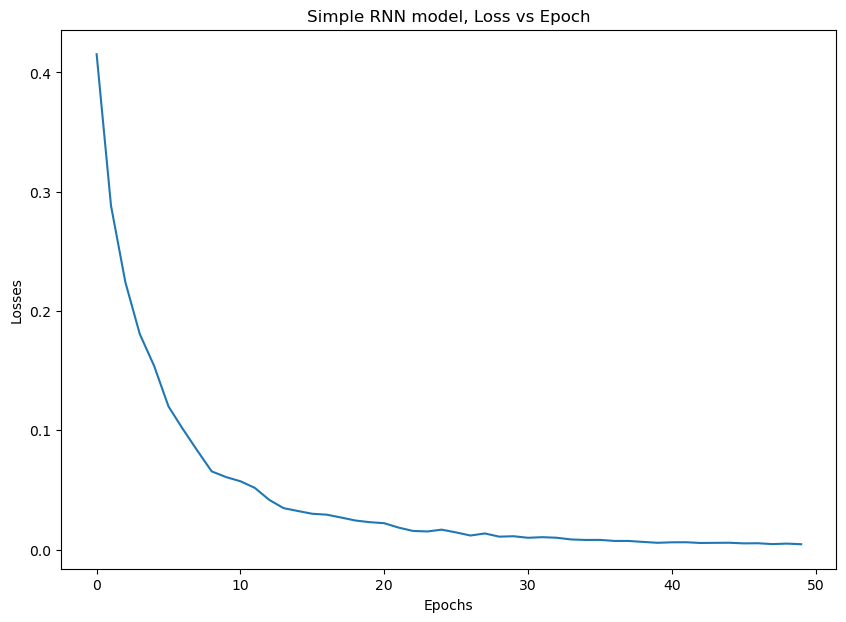

In [44]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

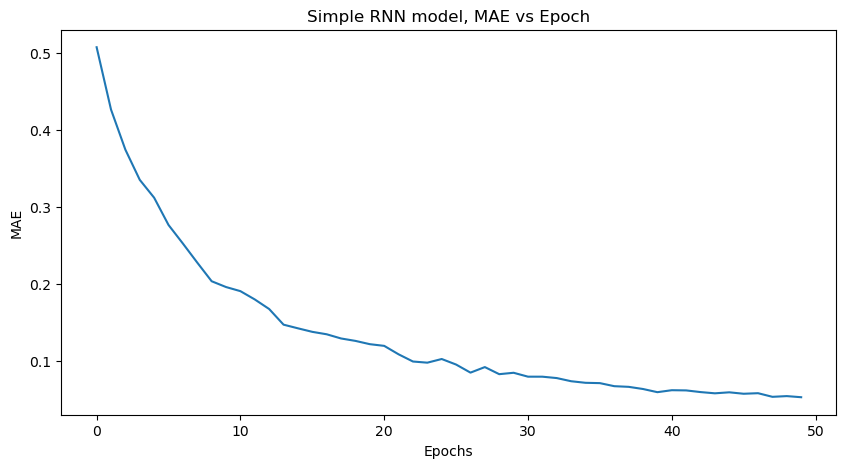

In [45]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["mae"])
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Simple RNN model, MAE vs Epoch")
plt.show()

# Model predictions for train data


In [47]:
y_pred = regressor.predict(X_train)  # # Predict the scaled values using the trained RNN model.

y_pred = scaler.inverse_transform(y_pred) # # Convert predictions back from scaled (0–1) values to original price units.

y_train = scaler.inverse_transform(y_train)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


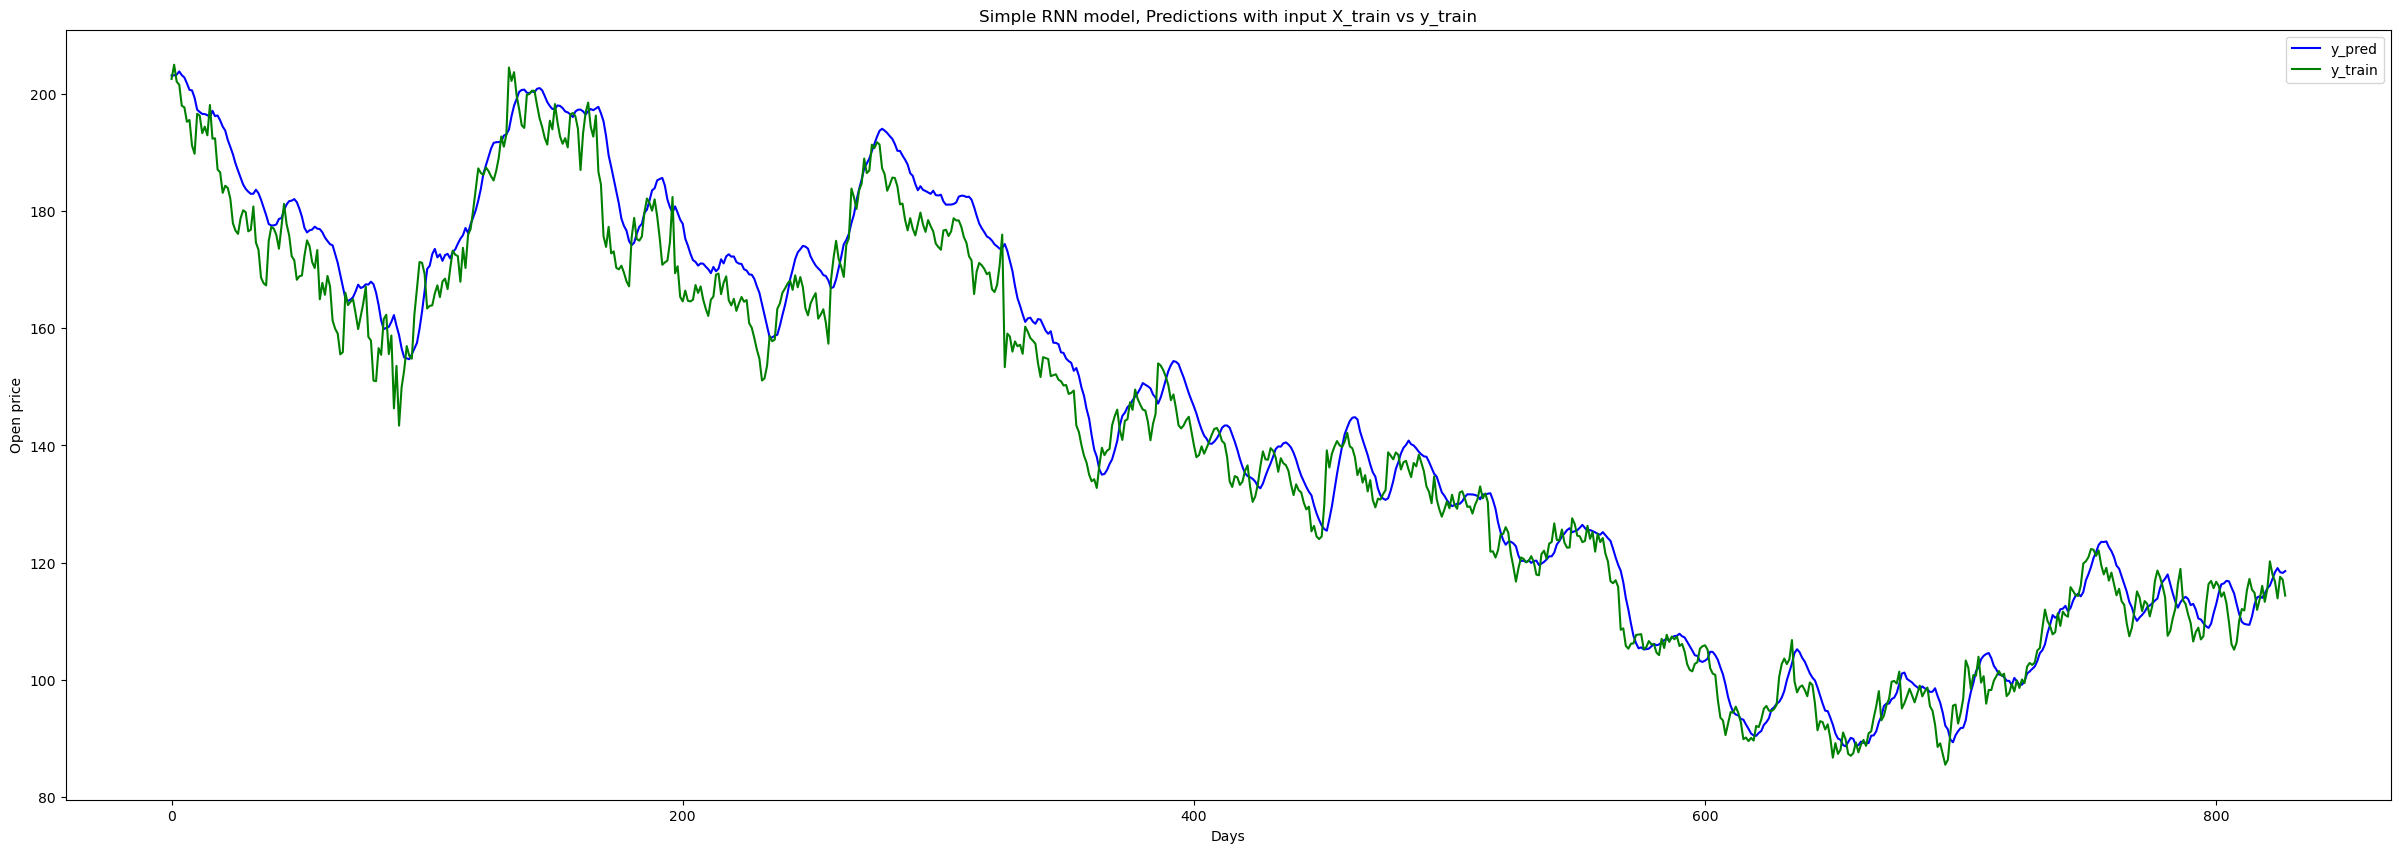

In [48]:
# We are visualizing the model's performance on the training data. If the model has learned correctly, both curves will overlap closely.
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

# Creating Test Dataset from Validation Data¶


In [50]:
# Convert validation data to 2D

dataset_validation = np.array( validation_data.Open)
dataset_validation = dataset_validation.reshape(-1, 1)

scaled_dataset_validation = scaler.transform(dataset_validation)
# scaled_dataset_validation

In [51]:
# Creating X_test and y_test

X_test = []
y_test = []

for i in range(time_step, length_validation_data):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

In [52]:
# Converting to array-

X_test, y_test = np.array(X_test), np.array(y_test)

In [53]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (327, 50)
Shape of y_test before reshape : (327,)


In [54]:
# Reshape-

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [55]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (327, 50, 1)
Shape of y_test after reshape : (327, 1)


# Evaluating with Validation Data-

In [57]:
# predictions with X_test data-
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Shape of y_pred_of_test : (327, 1)


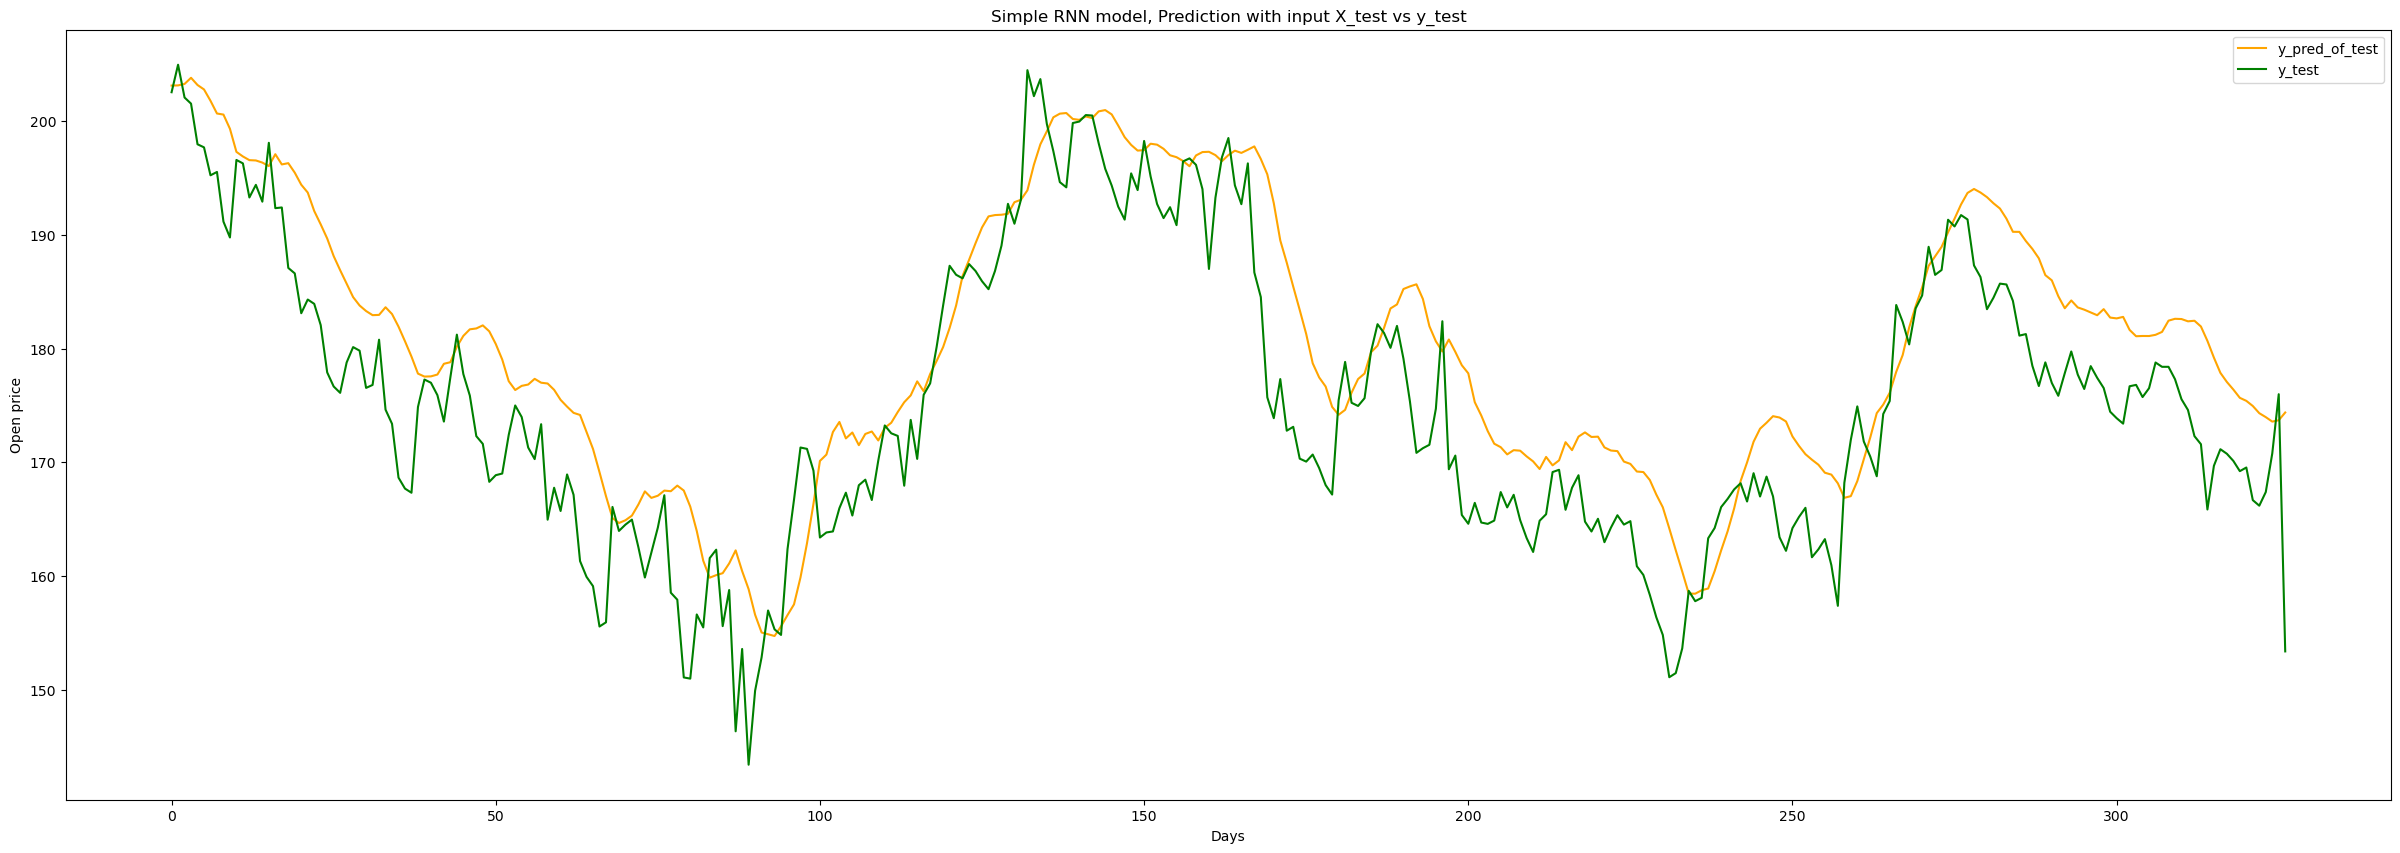

In [58]:
# visualisation -  We are Visualizing the model's performance on the testing(validation) data. If the model has learned correctly, both curves will overlap closely.
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [59]:
train_data["Open"] = train_data["Open"]
validation_data["Open"] = validation_data["Open"]


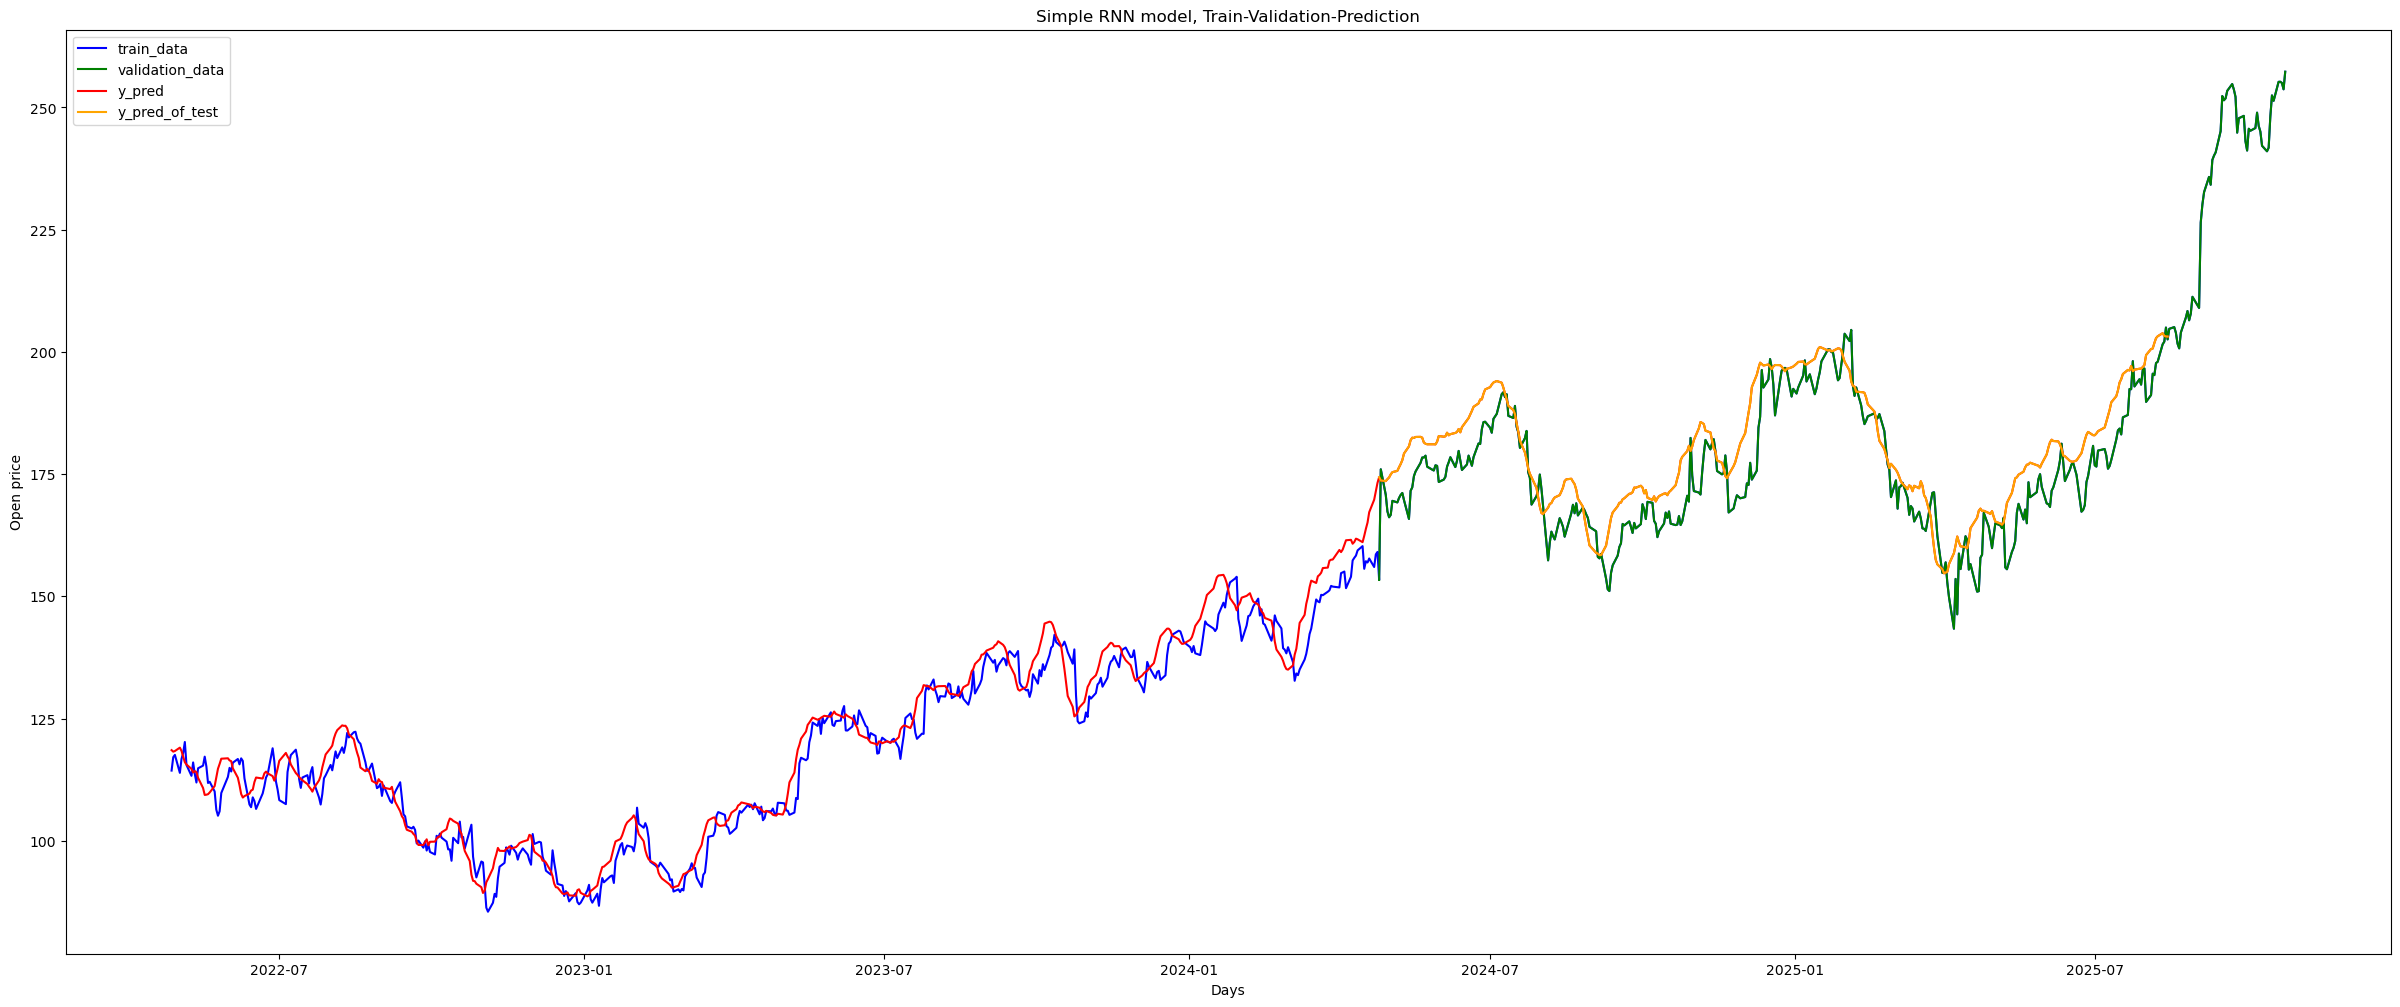

In [60]:
# Visualisation- Here we are # Plotting actual vs predicted prices for both training and validation sets to visualize model performance.

plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

In [61]:
# Here we are  Evaluating training performance by comparing true training values with predicted values using MSE and RMSE.

from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(
    train_data.Open.iloc[time_step:],   
    y_pred                              
)

print("MSE (train vs y_pred):", mse_train)
print("RMSE (train vs y_pred):",mse_train**0.5)


MSE (train vs y_pred): 31.53061075842413
RMSE (train vs y_pred): 5.6152124410768405


In [62]:
# Here we are  Compute MSE and RMSE between actual validation prices and the model's predicted validation prices.


from sklearn.metrics import mean_squared_error

mse_val = mean_squared_error(
    validation_data.Open.iloc[time_step:],   
    y_pred_of_test                           
)

print("MSE (validation vs y_pred_of_test):", mse_val)
print("RMSE (validation vs y_pred_of_test):",mse_train**0.5)



MSE (validation vs y_pred_of_test): 51.048047056877344
RMSE (validation vs y_pred_of_test): 5.6152124410768405


# Applying LSTM -

In [64]:
y_train = scaler.fit_transform(y_train)

In [65]:
# # Building and training a stacked LSTM model to predict the next-day open price from past time steps.
# A 2-layer LSTM model with 64 units each, followed by Dense layers, compiled with MSE loss and trained on the scaled sequences to predict the next time-step price.


from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mae"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10


C:\Users\harry\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0164 - mae: 0.0825
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - mae: 0.0399
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - mae: 0.0368
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0025 - mae: 0.0392
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021 - mae: 0.0359
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - mae: 0.0340
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - mae: 0.0345
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0317
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0324
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - mae: 0.0298


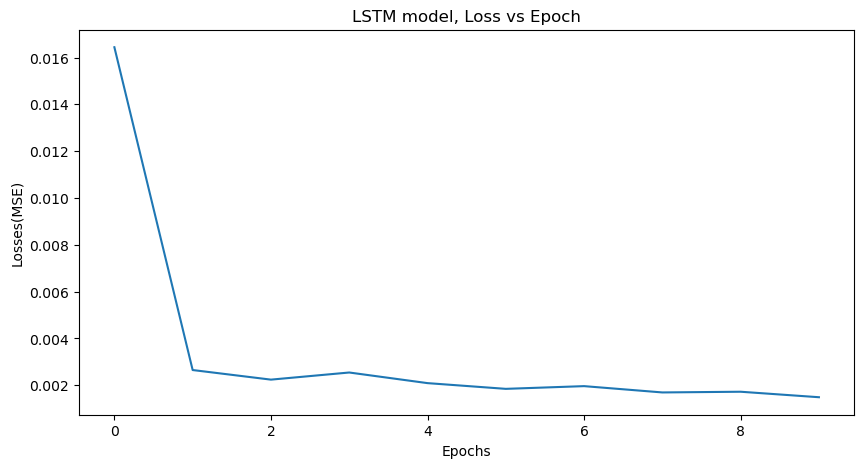

In [66]:
# Evaluating LSTM Model-
# # Plotting the LSTM model's training loss(MSE) across epochs.

plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses(MSE)")
plt.title("LSTM model, Loss vs Epoch")
plt.show()


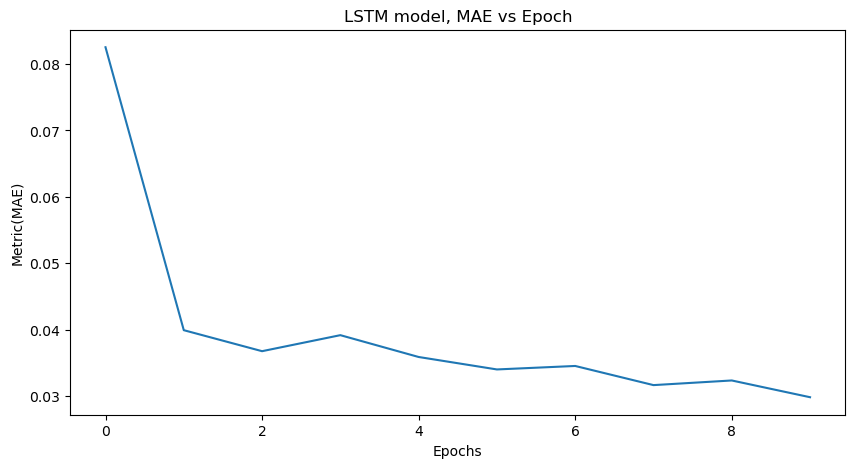

In [67]:
# # Plotting the LSTM model's MAE metric across epochs to evaluate training performance.

plt.figure(figsize =(10,5))
plt.plot(history2.history["mae"])
plt.xlabel("Epochs")
plt.ylabel("Metric(MAE)")
plt.title("LSTM model, MAE vs Epoch")
plt.show()


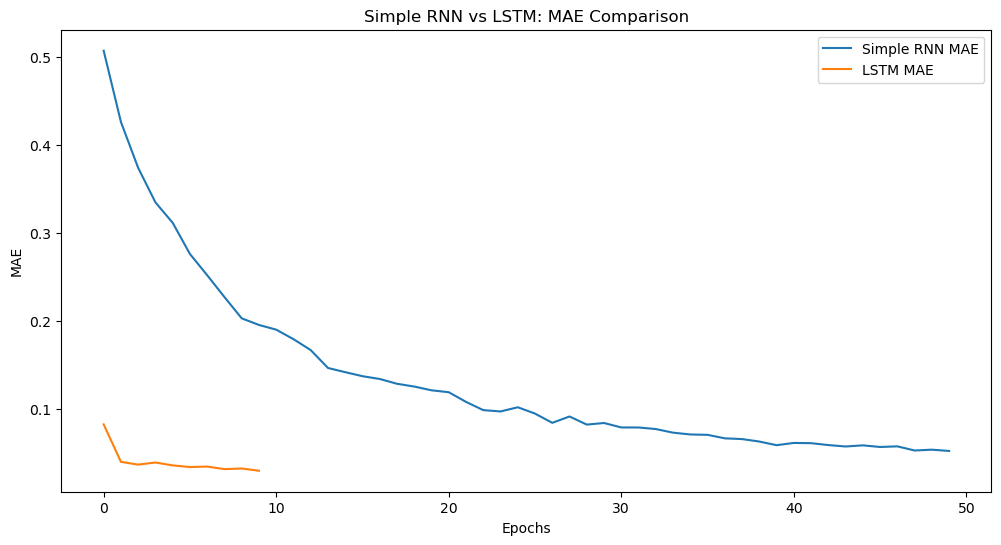

In [68]:
plt.figure(figsize=(12,6))
plt.plot(history.history["mae"], label="Simple RNN MAE")
plt.plot(history2.history["mae"], label="LSTM MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Simple RNN vs LSTM: MAE Comparison")
plt.legend()
plt.show()


In [69]:
# So, we can see LSTM clearly performs better than Simple RNN.
# It learns faster, gives much lower MAE, and is more stable.

In [70]:
y_train = scaler.inverse_transform(y_train)

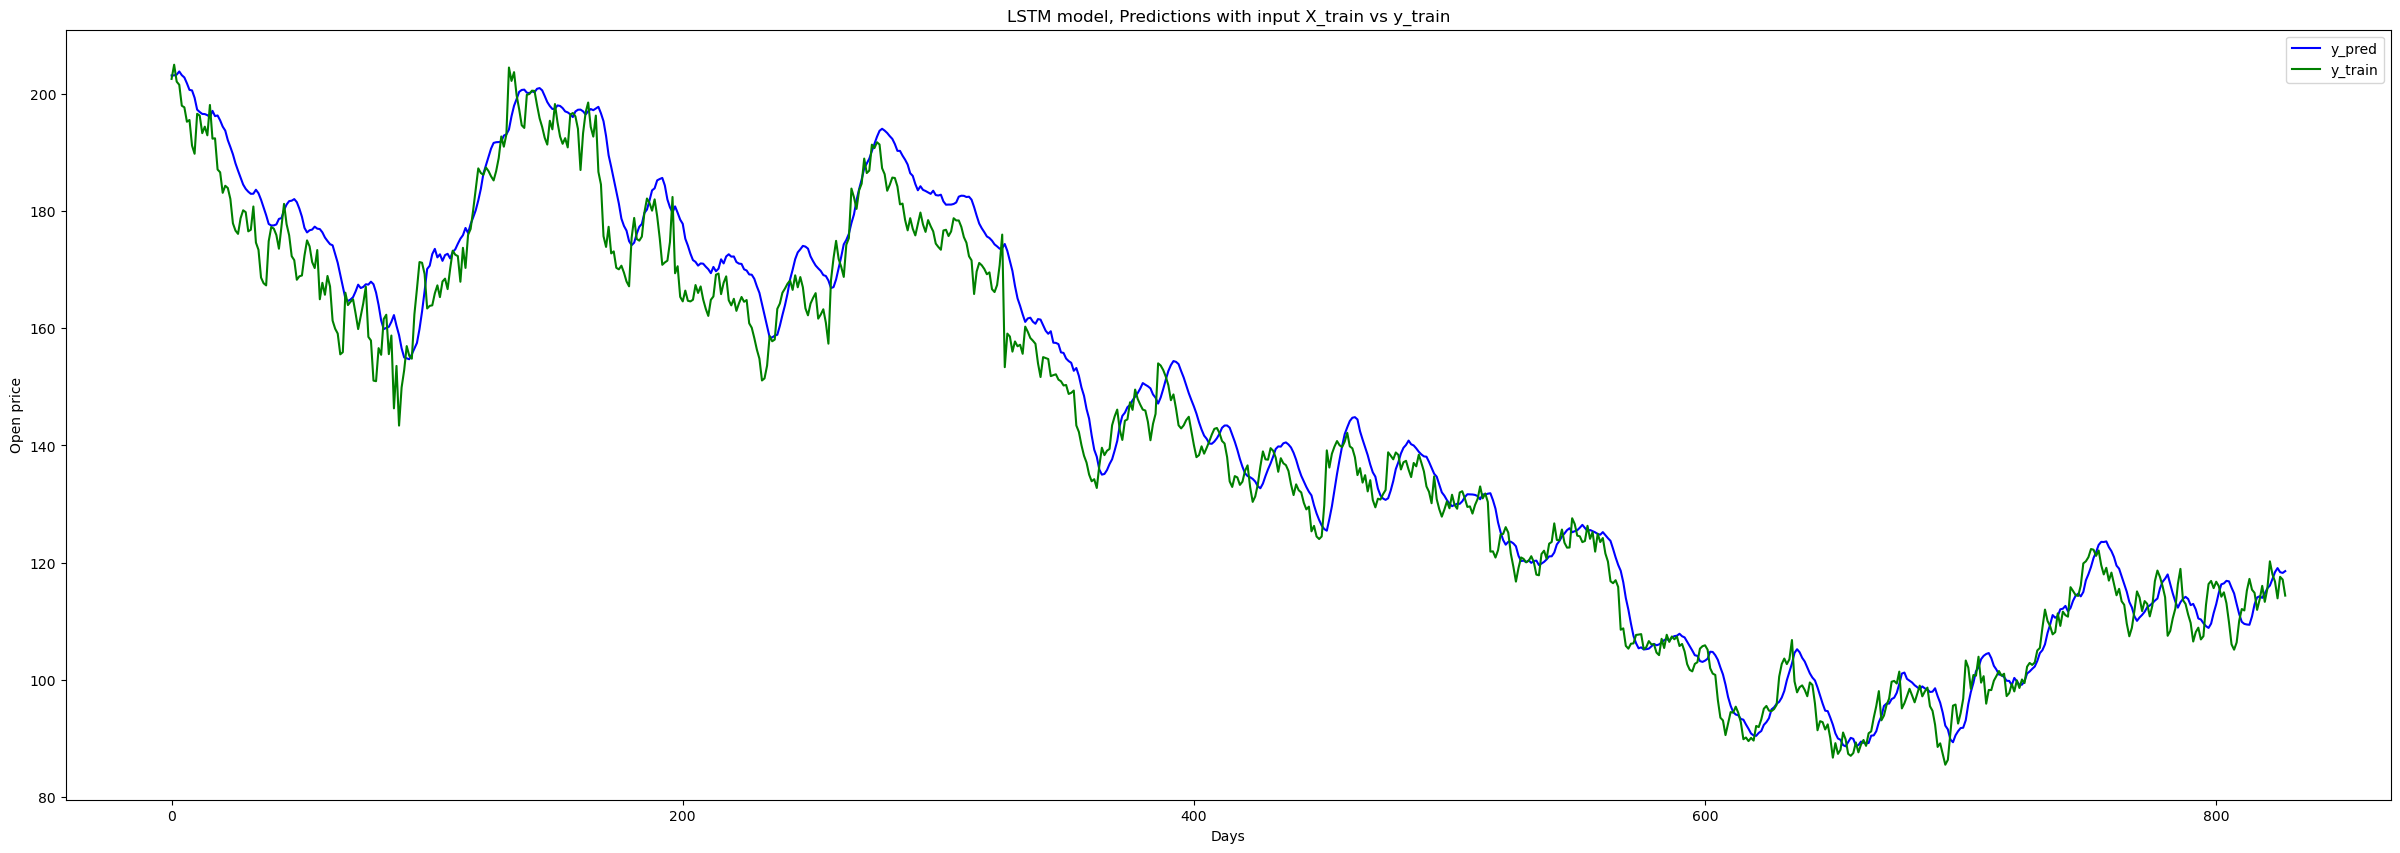

In [71]:
# We are visualizing the model's performance on the training data. If the model has learned correctly, both curves will overlap closely.
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [72]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_test.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mae"])
history2 = model_lstm.fit(X_test, y_test, epochs = 10, batch_size = 10)

C:\Users\harry\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0269 - mae: 0.1118
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - mae: 0.0335
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - mae: 0.0315
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0301
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - mae: 0.0307
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0289
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0286
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0290
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0294
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - mae: 0.0297


In [73]:
# predictions with X_test data-
y_pred_of_test = model_lstm.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Shape of y_pred_of_test : (327, 1)


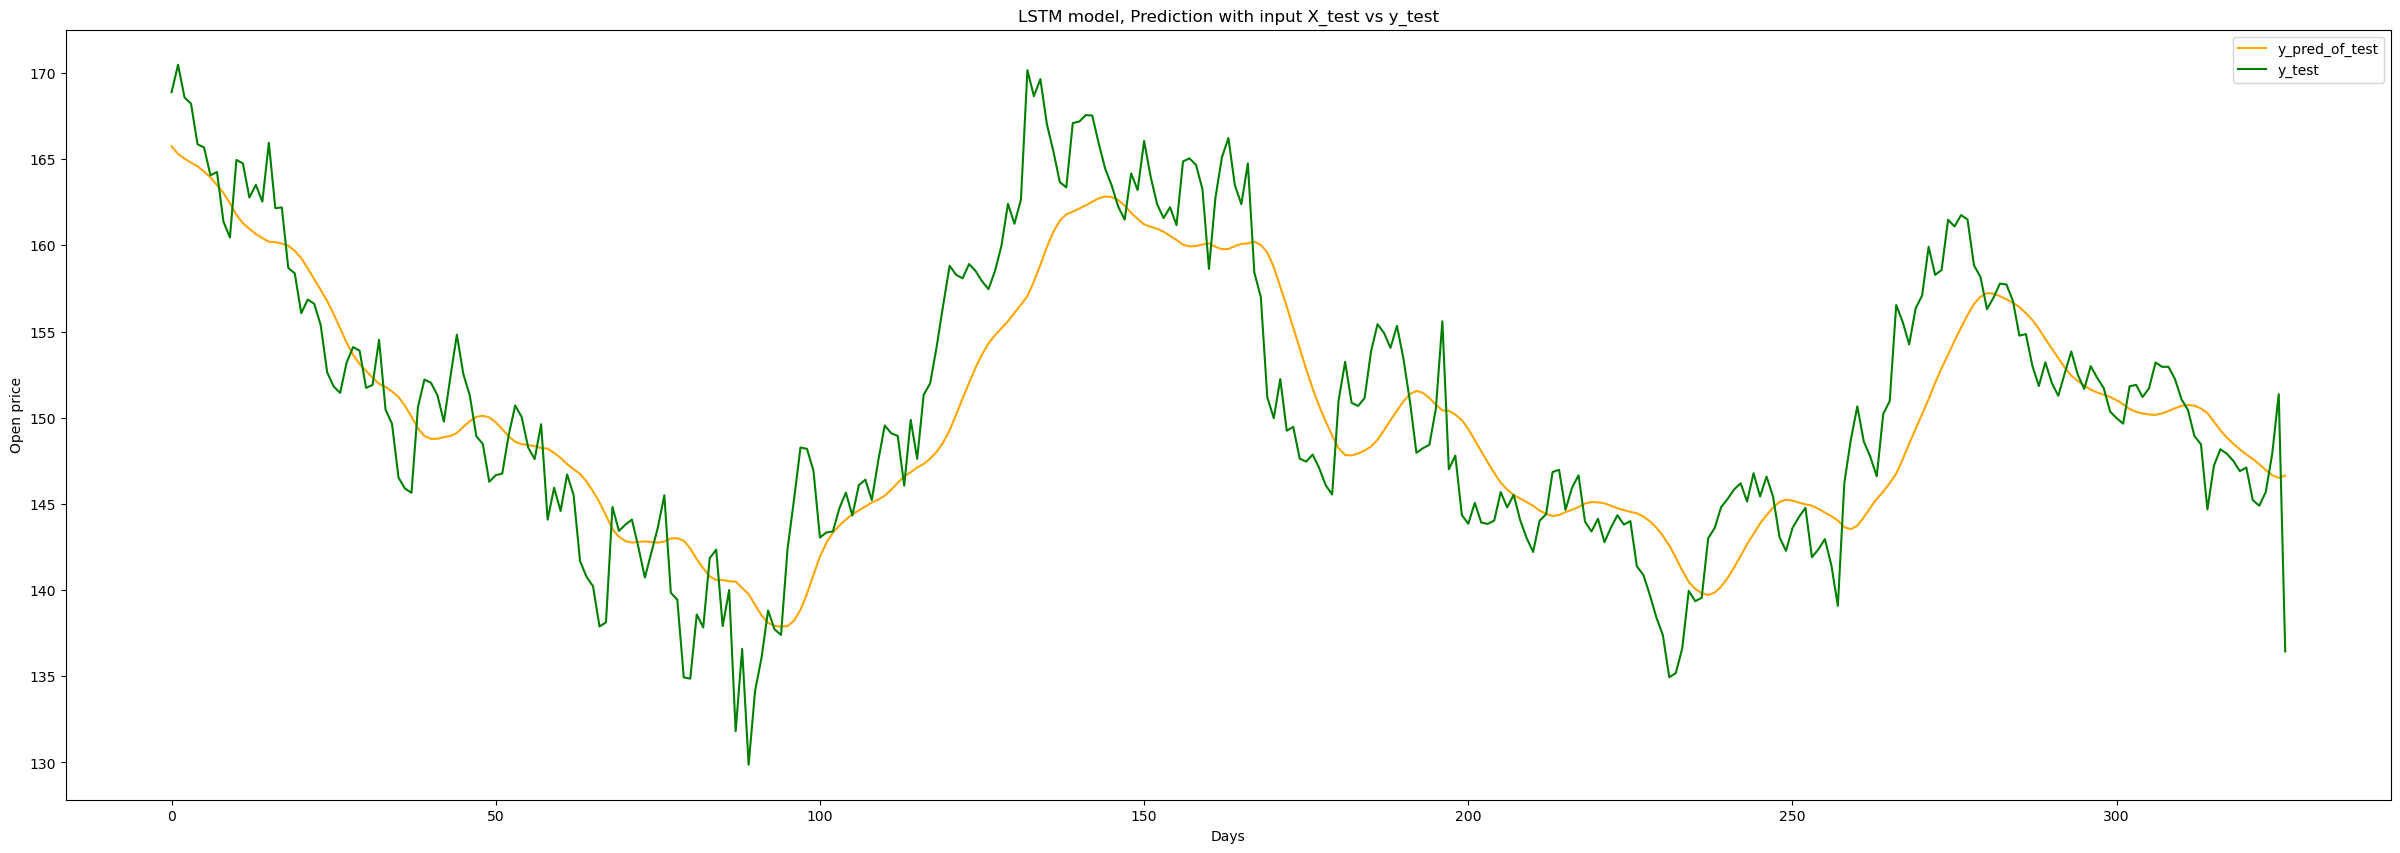

In [74]:
# visualisation -  We are Visualizing the model's performance on the testing(validation) data. If the model has learned correctly, both curves will overlap closely.
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()